In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



**GOAL**
1. Validate whether Elena’s suggested perks are attractive to users.
2. Assign each user to a segment based on their likely preferred perk, using behavioral data.



**Define the Cohort**

Filter the sessions to only include:


*   session_start >= 2023-01-04
*   Group by user_id, count the number of sessions per user
*   Keep only users with more than 7 sessions

This ensures we're analyzing engaged users with meaningful behavior patterns.








# **SQL Queries**

**Cohort definition**






In [ ]:

WITH session_counts AS (
  SELECT user_id, COUNT(*) AS session_count
  FROM sessions
  WHERE session_start >= '2023-01-04'
  GROUP BY user_id
)
SELECT *
FROM users
WHERE user_id IN (
  SELECT user_id FROM session_counts WHERE session_count > 7
);


SyntaxError: invalid syntax (<ipython-input-6-af276805f7c4>, line 1)

# **Feature Engineering: Metrics by Perk**


Metrics that act as behavioral signals for each of the five candidate perks.


**Perk A) Free hotel meal**
This query calculates how many distinct trips a user has booked with a hotel (hotel_bookings). It joins the hotels table to the sessions table, filters by sessions that started after January 4, 2023, and groups by user_id.


In [ ]:
SELECT user_id, COUNT(DISTINCT h.trip_id) AS hotel_bookings
FROM hotels h
JOIN sessions s ON h.trip_id = s.trip_id
WHERE s.session_start >= '2023-01-04'
GROUP BY user_id;


**Perk B) Free checked bag**
This query calculates the average number of checked bags (avg_checked_bags) per user. It joins the flights table with the sessions table, filters by sessions from January 4, 2023, onwards, and groups by user_id.


In [ ]:
SELECT user_id, AVG(f.checked_bags) AS avg_checked_bags
FROM flights f
JOIN sessions s ON f.trip_id = s.trip_id
WHERE s.session_start >= '2023-01-04'
GROUP BY user_id;


**Perk C) No cancellation fees**
This query counts how many times a user has canceled a trip (cancel_count). It only includes sessions where the cancellation flag is TRUE.


In [ ]:
SELECT user_id, COUNT(*) AS cancel_count
FROM sessions
WHERE session_start >= '2023-01-04' AND cancellation = 1
GROUP BY user_id;


**Perk D) Exclusive discounts**
This query calculates the rate at which users are exposed to flight and hotel discounts. It uses CASE statements to check if the flight or hotel discounts were offered (flight_discount and hotel_discount) and computes the average for each user.


In [ ]:
SELECT user_id,
       AVG(CASE WHEN flight_discount = 1 THEN 1 ELSE 0 END) AS flight_discount_rate,
       AVG(CASE WHEN hotel_discount = 1 THEN 1 ELSE 0 END) AS hotel_discount_rate
FROM sessions
WHERE session_start >= '2023-01-04'
GROUP BY user_id;


**Perk E) 1 night free hotel with flight**
This query counts the total trips (total_trips) and the trips where both flights and hotels were booked together (flight_and_hotel_trips) for each user. It joins the sessions table to the flights and hotels tables.


In [ ]:
SELECT user_id,
       COUNT(DISTINCT s.trip_id) AS total_trips,
       COUNT(DISTINCT CASE WHEN f.trip_id IS NOT NULL AND h.trip_id IS NOT NULL THEN s.trip_id END) AS flight_and_hotel_trips
FROM sessions s
LEFT JOIN flights f ON s.trip_id = f.trip_id
LEFT JOIN hotels h ON s.trip_id = h.trip_id
WHERE s.session_start >= '2023-01-04'
GROUP BY user_id;



# **Combine Metrics**

**Version A) strict**
We merge all perk-related metrics to form a user-level table for segmentation.

Perk assignment logic: Based on the metrics we calculated in the CTEs, we use the GREATEST function to find the metric with the highest value for each user.


In [ ]:
WITH hotel_bookings AS (
    SELECT user_id, COUNT(DISTINCT h.trip_id) AS hotel_bookings
    FROM hotels h
    JOIN sessions s ON h.trip_id = s.trip_id
    WHERE s.session_start >= '2023-01-04'
    GROUP BY user_id
),

avg_checked_bags AS (
    SELECT user_id, AVG(f.checked_bags) AS avg_checked_bags
    FROM flights f
    JOIN sessions s ON f.trip_id = s.trip_id
    WHERE s.session_start >= '2023-01-04'
    GROUP BY user_id
),

cancel_counts AS (
    SELECT user_id, COUNT(*) AS cancel_count
    FROM sessions
    WHERE session_start >= '2023-01-04' AND cancellation = TRUE
    GROUP BY user_id
),

discount_rates AS (
    SELECT user_id,
           AVG(CASE WHEN flight_discount THEN 1 ELSE 0 END) AS flight_discount_rate,
           AVG(CASE WHEN hotel_discount THEN 1 ELSE 0 END) AS hotel_discount_rate
    FROM sessions
    WHERE session_start >= '2023-01-04'
    GROUP BY user_id
),

combo_trips AS (
    SELECT user_id,
           COUNT(DISTINCT s.trip_id) AS total_trips,
           COUNT(DISTINCT CASE WHEN f.trip_id IS NOT NULL AND h.trip_id IS NOT NULL THEN s.trip_id END) AS flight_and_hotel_trips
    FROM sessions s
    LEFT JOIN flights f ON s.trip_id = f.trip_id
    LEFT JOIN hotels h ON s.trip_id = h.trip_id
    WHERE s.session_start >= '2023-01-04'
    GROUP BY user_id
)

SELECT
    u.user_id,
    COALESCE(hb.hotel_bookings, 0) AS hotel_bookings,
    COALESCE(cb.avg_checked_bags, 0) AS avg_checked_bags,
    COALESCE(cc.cancel_count, 0) AS cancel_count,
    COALESCE(dr.flight_discount_rate, 0) AS flight_discount_rate,
    COALESCE(dr.hotel_discount_rate, 0) AS hotel_discount_rate,
    COALESCE(ct.flight_and_hotel_trips, 0) AS flight_and_hotel_trips,

    -- 🏷️ Favorite Perk Assignment
    CASE
        WHEN GREATEST(
            COALESCE(hb.hotel_bookings, 0),
            COALESCE(cb.avg_checked_bags, 0),
            COALESCE(cc.cancel_count, 0),
            COALESCE(dr.flight_discount_rate + dr.hotel_discount_rate, 0),
            COALESCE(ct.flight_and_hotel_trips, 0)
        ) = COALESCE(hb.hotel_bookings, 0)
        THEN 'Free hotel meal'

        WHEN GREATEST(
            COALESCE(hb.hotel_bookings, 0),
            COALESCE(cb.avg_checked_bags, 0),
            COALESCE(cc.cancel_count, 0),
            COALESCE(dr.flight_discount_rate + dr.hotel_discount_rate, 0),
            COALESCE(ct.flight_and_hotel_trips, 0)
        ) = COALESCE(cb.avg_checked_bags, 0)
        THEN 'Free checked bag'

        WHEN GREATEST(
            COALESCE(hb.hotel_bookings, 0),
            COALESCE(cb.avg_checked_bags, 0),
            COALESCE(cc.cancel_count, 0),
            COALESCE(dr.flight_discount_rate + dr.hotel_discount_rate, 0),
            COALESCE(ct.flight_and_hotel_trips, 0)
        ) = COALESCE(cc.cancel_count, 0)
        THEN 'No cancellation fees'

        WHEN GREATEST(
            COALESCE(hb.hotel_bookings, 0),
            COALESCE(cb.avg_checked_bags, 0),
            COALESCE(cc.cancel_count, 0),
            COALESCE(dr.flight_discount_rate + dr.hotel_discount_rate, 0),
            COALESCE(ct.flight_and_hotel_trips, 0)
        ) = COALESCE(dr.flight_discount_rate + dr.hotel_discount_rate, 0)
        THEN 'Exclusive discounts'

        ELSE '1 night free hotel with flight'
    END AS favorite_perk

FROM (
    SELECT user_id
    FROM sessions
    WHERE session_start >= '2023-01-04'
    GROUP BY user_id
    HAVING COUNT(*) > 7
) u
LEFT JOIN hotel_bookings hb ON u.user_id = hb.user_id
LEFT JOIN avg_checked_bags cb ON u.user_id = cb.user_id
LEFT JOIN cancel_counts cc ON u.user_id = cc.user_id
LEFT JOIN discount_rates dr ON u.user_id = dr.user_id
LEFT JOIN combo_trips ct ON u.user_id = ct.user_id;


In [ ]:
from google.colab import files
import pandas as pd

uploaded = files.upload()

Saving user_perk_assignment.csv to user_perk_assignment.csv


**Perk** | *Metric*  **>>**  Logic


*   **Free hotel meal** | *hotel_bookings* **>>** High hotel booking activity
*   **Free checked bag** | *avg_checked_bags* **>>** High average number of checked bags
*   **No cancellation fees** | *cancel_count* **>>** Frequent cancellers
*   **Exclusive discounts** | *flight_discount_rate + hotel_discount_rate* **>>** Often exposed to or influenced by discounts
*   **1 night free hotel with flight** | *flight_and_hotel_trips* **>>** Books both flights and hotels together often





# **Combine Metrics**

**Version B) scale-based**

A scale-based approach will give us more flexibility when users have the same score for two or more metrics, and it will allow us to prioritize which perk should be assigned if there is a tie.

I merge all perk-related metrics to form a user-level table for segmentation.

Perk assignment logic: Based on the metrics we calculated in the CTEs, we use the GREATEST function to find the metric with the highest value for each user.

I´ll create a scale for each metric (e.g., hotel bookings, average checked bags, cancellation count, etc.), where users are given a score between 1 and 5 based on their performance in each area. The higher the value, the more likely the user is to prefer that perk.

**For example:**
*Hotel bookings*: If a user has 0 bookings, they get a score of 1. If they have 5 or more bookings, they get a score of 5, with a linear scale between them.

*Checked bags*: If the average checked bags are 0, score them as 1. If it’s above a certain threshold, score them higher.

In [ ]:
df = pd.read_csv('user_perk_assignment.csv')

<ipython-input-4-e85ae411ddd7>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='favorite_perk', order=df['favorite_perk'].value_counts().index, palette='coolwarm')


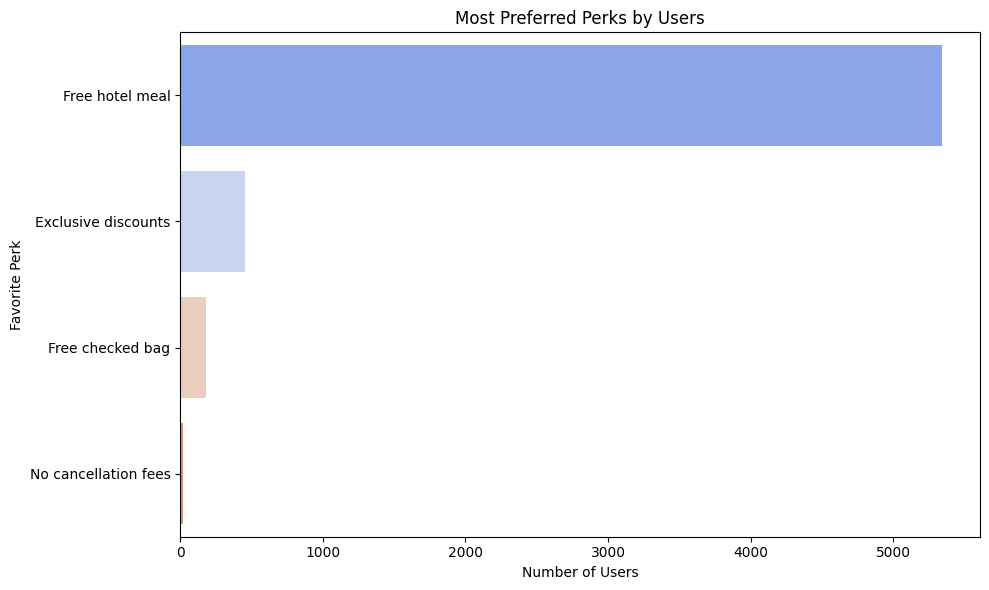

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='favorite_perk', order=df['favorite_perk'].value_counts().index, palette='coolwarm')
plt.title('Most Preferred Perks by Users')
plt.xlabel('Number of Users')
plt.ylabel('Favorite Perk')
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files
import pandas as pd

uploaded = files.upload()

Saving user_perk_assignment_5scale.csv to user_perk_assignment_5scale.csv


In [ ]:
df = pd.read_csv('user_perk_assignment_5scale.csv')


<ipython-input-9-e85ae411ddd7>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='favorite_perk', order=df['favorite_perk'].value_counts().index, palette='coolwarm')


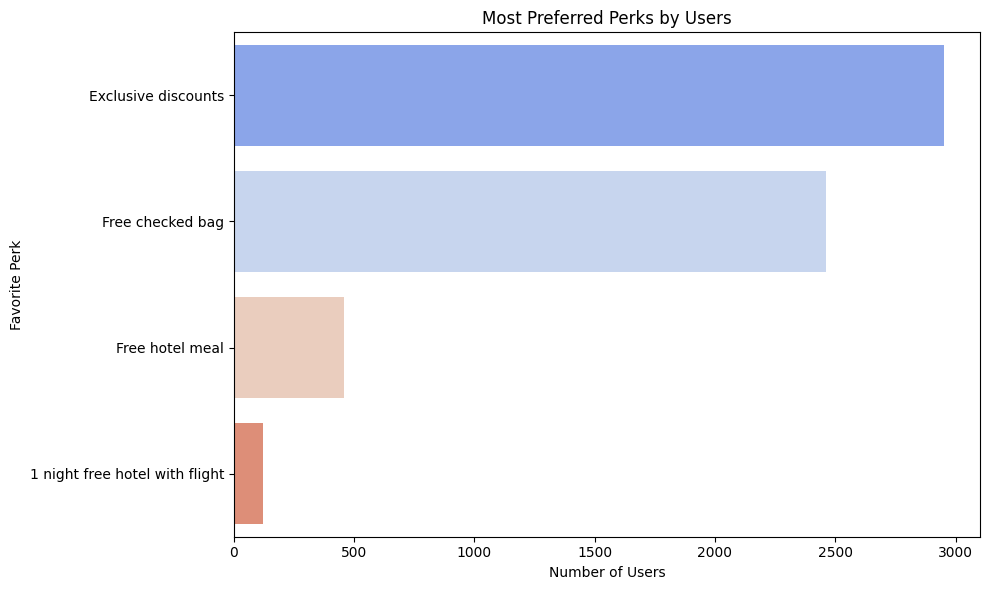

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='favorite_perk', order=df['favorite_perk'].value_counts().index, palette='coolwarm')
plt.title('Most Preferred Perks by Users')
plt.xlabel('Number of Users')
plt.ylabel('Favorite Perk')
plt.tight_layout()
plt.show()


Recomandation

